In [1]:
import pandas as pd
import numpy as np
import json
import seaborn
import warnings
%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [25]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)

In [3]:
data = pd.read_csv('C:/TZ_GP (2).csv')

#### Приведение к доступной форме: даты, сериализация json, нумерация всех пользователей (со словарём)

In [4]:
from datetime import datetime, timedelta
data.client_time = data.client_time.apply(lambda _: datetime.strptime(_,"%Y-%m-%d %H:%M:%S"))
data.game_status = data.game_status.apply(lambda _: json.loads(_))
data.event_data = data.event_data.apply(lambda _: json.loads(_))

In [5]:
userdict = {}
for i, value in enumerate(set(data.user_id)):
    userdict[value] = i
data.user_id = data.user_id.apply(lambda _: userdict[_])

#### Измерение данных производилось за неделю.

In [6]:
max(data.client_time) - min(data.client_time)

Timedelta('7 days 23:55:28')

#### Количество пользователей, установивших приложение за неделю - 452
#### Количество уникальных пользователей - 452. То есть все пользователи новые.

In [7]:
usrcnt=0
for i, row in enumerate(data.event_name):
    if row == 'appInstall':
        #print(data.event_data.iloc[i])
        usrcnt+=1
print('Users:' + (str(usrcnt)))

Users:452


In [8]:
data.head()

,user_id,media_source,client_time,session_index,game_status,event_name,event_data
0,182,organic,2021-06...,1,{'coin...,appIns...,{'devi...
1,428,organic,2021-06...,1,{'coin...,appIns...,{'devi...
2,423,ad-tra...,2021-06...,1,{'coin...,appIns...,{'devi...
3,194,ad-tra...,2021-06...,1,{'coin...,appIns...,{'devi...
4,331,organic,2021-06...,1,{'coin...,appIns...,{'devi...


### Вывод всех транзакций

In [9]:
from collections import defaultdict
# Вывод всех экземпляров json-элемента из event_data
def view_data(column, Frame):
    my_list = Frame.event_data.values
    my_dict_list = defaultdict(list)
    for value in my_list:
        for k,v in value.items():
            my_dict_list[k].append(v)
    return(my_dict_list[column])

In [10]:
# Вывод всех экземпляров json-элемента column из event_data для каждого пользователя из DataFrame Frame
def view_user_data(column, Frame):
    my_list = Frame.event_data.values
    my_dict_list = defaultdict(list)
    for value in my_list:
        for k,v in value.items():
            my_dict_list[k].append(v)
    newColumn = pd.Series(my_dict_list[column])
    newFrame = Frame.copy()
    newFrame[column] = newColumn.values
    return(newFrame[['user_id',column]])

In [11]:
usdFrame = view_user_data('usdProceed', data.where(data.event_name == 'transactionComplete').dropna(how='all'))
usdFrame

,user_id,usdProceed
396062,154.0,5.243000
396063,22.0,1.391999
396064,22.0,1.391999
396065,256.0,5.243000
396066,264.0,5.243000
...,...,...
396094,401.0,68.176809
396095,401.0,6.810010
396096,401.0,13.628543
396097,304.0,1.393000


#### Максимальный донат 68 долларов

In [12]:
transactions = data.where(data.event_name == 'transactionComplete').dropna(how='all')[['user_id','event_data']]
max(view_data('usdProceed',transactions))

68.1768094378241

## Получено 478.49 USD за неделю, из них 56,57 USD с рекламы

In [13]:
sum(view_data('usdProceed',
              data.where(data.event_name == 'transactionComplete').dropna(how='all')))

478.4979987325356

In [14]:
sum(view_data('usdProceed',
              data.where(data.event_name == 'transactionComplete').
              where(data.media_source=='ad-traffic').dropna(how='all')))

56.5762952652839

## Донатило 12 пользователей, из них 7 с рекламы

In [15]:
len(set(data.where(data.event_name == 'transactionComplete').dropna(how='all').sort_values('user_id').user_id.values))

12

In [16]:
len(set(data.where(data.event_name == 'transactionComplete').where(data.media_source=='ad-traffic').dropna(how='all').sort_values('user_id').user_id.values))

7

## Анализ обучения пользователей

LearningArray - массив из датафреймов пользователей до прохождения первой грядки. AllLearnedArray такой же, но в нём присутствуют необученные пользователи.
unlearned - индексы необученных пользователей. 
learned - индексы пользователей, прошедших обучение. 
UnlearnedArray - массив из датафреймов только необученных пользователей. 
LearnedArray - массив из датафреймов только обученных пользователей. 
UserArray - разбиение исходного датасета по каждому пользователю.

In [17]:
def LearningCutter(user_id):
    for i, value in enumerate(data.where(data.user_id == user_id).dropna(how='all').sort_values('client_time').event_name):
        if value == 'gladeComplete':
            UserFrame = data.where(data.user_id == user_id).dropna(how='all').sort_values('client_time').iloc[0:i+1]
            return UserFrame

In [18]:
LearningArray = []
for x in range(0,usrcnt):
    LearningArray.append(LearningCutter(x))

In [19]:
unlearned = []
learned = []
for i, value in enumerate(LearningArray):
    if value is None:
        unlearned.append(i)
    else:
        learned.append(i)

In [20]:
AllLearnedArray = LearningArray.copy()
for i in (unlearned):
    AllLearnedArray[i]=data.where(data.user_id==i).dropna(how='all').sort_values('client_time')    
LearningArray = [x for x in LearningArray if (x is not None)]

In [21]:
UserArray = []
for x in range(0,usrcnt):
    UserArray.append(data.where(data.user_id == x).dropna(how='all').sort_values('client_time'))

In [22]:
UnlearnedArray = []
for i in (unlearned):
    UnlearnedArray.append(data.where(data.user_id==i).dropna(how='all').sort_values('client_time'))

In [23]:
LearnedArray = []
for i in (learned):
    LearnedArray.append(data.where(data.user_id==i).dropna(how='all').sort_values('client_time'))

In [24]:
UnlearnedTime = []
for user in UnlearnedArray:
    UnlearnedTime.append(user.client_time.iloc[-1]-user.client_time.iloc[0])

#### Длины датафреймов массивов: UnlearnedArray + LearningArray = AllLearnedArray < LearnedArray  < UserArray

In [26]:
UserArray[0]

,user_id,media_source,client_time,session_index,game_status,event_name,event_data
56,0.0,ad-traffic,2021-06-05 03:38:22,1.0,"{'coins': 0, 'freeRounds': 0, 'freeUndo': 0, 'freeWildCard': 0, 'freeAddCards': 0, 'level': 0, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0}",appInstall,"{'device': 'motorola moto e(6) plus', 'graphicMemory': 512, 'systemMemory': 1849}"
4804,0.0,ad-traffic,2021-06-05 03:38:50,1.0,"{'coins': 0, 'freeRounds': 0, 'freeUndo': 3, 'freeWildCard': 0, 'freeAddCards': 0, 'level': 0, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0}",getBooster,"{'type': 'freeUndo', 'from': 'FirstGift', 'amount': 3}"
4805,0.0,ad-traffic,2021-06-05 03:38:50,1.0,"{'coins': 0, 'freeRounds': 0, 'freeUndo': 3, 'freeWildCard': 0, 'freeAddCards': 3, 'level': 0, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0}",getBooster,"{'type': 'freeExtraCards', 'from': 'FirstGift', 'amount': 3}"
4806,0.0,ad-traffic,2021-06-05 03:38:50,1.0,"{'coins': 0, 'freeRounds': 0, 'freeUndo': 3, 'freeWildCard': 3, 'freeAddCards': 3, 'level': 0, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0}",getBooster,"{'type': 'freeWildCard', 'from': 'FirstGift', 'amount': 3}"
342108,0.0,ad-traffic,2021-06-05 03:38:51,1.0,"{'coins': 5000, 'freeRounds': 0, 'freeUndo': 3, 'freeWildCard': 3, 'freeAddCards': 3, 'level': 1, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0, 'gameType': 0}",levelStart,"{'retry': False, 'level': 1, 'levelLoop': 1, 'gameType': 0, 'price': 1000, 'cardsInHand': 15, 'baseLuckyIndex': 0, 'targetGoldIndex': 0, 'targetCoins': 0, 'totalLuckyIndex': 0, 'prediction': 'Default'}"
...,...,...,...,...,...,...,...
332790,0.0,ad-traffic,2021-06-07 09:11:48,3.0,"{'coins': 6531, 'freeRounds': 0, 'freeUndo': 0, 'freeWildCard': 5, 'freeAddCards': 0, 'level': 51, 'map': 1, 'bet': 2, 'gladeId': 3, 'league': 0, 'gameType': 0}",learning,"{'name': 'CRUISE_NEXT_CARD', 'level': 19}"
375814,0.0,ad-traffic,2021-06-07 09:11:55,3.0,"{'coins': 2531, 'freeRounds': 0, 'freeUndo': 0, 'freeWildCard': 5, 'freeAddCards': 0, 'level': 51, 'map': 1, 'bet': 2, 'gladeId': 3, 'league': 0, 'gameType': 0}",getCoins,"{'amount': -4000, 'from': 'UndoDropCard'}"
332791,0.0,ad-traffic,2021-06-07 09:11:57,3.0,"{'coins': 2531, 'freeRounds': 0, 'freeUndo': 0, 'freeWildCard': 5, 'freeAddCards': 0, 'level': 51, 'map': 1, 'bet': 2, 'gladeId': 3, 'league': 0, 'gameType': 0}",learning,"{'name': 'CRUISE_NEXT_CARD', 'level': 19}"
55518,0.0,ad-traffic,2021-06-07 09:12:23,3.0,"{'coins': 2531, 'freeRounds': 0, 'freeUndo': 0, 'freeWildCard': 4, 'freeAddCards': 0, 'level': 51, 'map': 1, 'bet': 2, 'gladeId': 3, 'league': 0, 'gameType': 0}",getBooster,"{'type': 'freeWildCard', 'from': 'UseInGame', 'amount': -1}"


### 35% игроков не прошли обучение

In [27]:
len(unlearned)/(len(learned)+len(unlearned))

0.35398230088495575

In [28]:
def InGameTimeCalculation(user_id, Array):
    time= timedelta(0)
    for i in set(Array[user_id].session_index.values):
        time+=Array[user_id].where(Array[user_id].session_index==i).dropna(how='all').sort_values('client_time').iloc[-1].client_time-Array[user_id].where(Array[user_id].session_index==i).dropna(how='all').sort_values('client_time').iloc[0].client_time
    return time

In [29]:
ans = []
for value in unlearned:
    ans.append(InGameTimeCalculation(value, UserArray))

#### 5 пользователей (вылетело) вышли сразу после запуска.

In [30]:
for i, value in enumerate(numpy.array(ans)):
    if value == timedelta(0,0,0):
        print(unlearned[i])

20
133
167
303
320


In [31]:
data.where(data.user_id==20).dropna(how='all')

,user_id,media_source,client_time,session_index,game_status,event_name,event_data
337,20.0,organic,2021-06-05 16:47:02,1.0,"{'coins': 0, 'freeRounds': 0, 'freeUndo': 0, 'freeWildCard': 0, 'freeAddCards': 0, 'level': 0, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0, 'VIPPointsAmount': 0, 'VIPStatus': 0}",appInstall,"{'device': 'HUAWEI MAR-LX1B', 'graphicMemory': 2048, 'systemMemory': 5722}"
24261,20.0,organic,2021-06-05 16:47:02,1.0,"{'coins': 0, 'freeRounds': 0, 'freeUndo': 3, 'freeWildCard': 0, 'freeAddCards': 0, 'level': 0, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0, 'VIPPointsAmount': 0, 'VIPStatus': 0}",getBooster,"{'type': 'freeUndo', 'from': 'FirstGift', 'amount': 3}"
24262,20.0,organic,2021-06-05 16:47:02,1.0,"{'coins': 0, 'freeRounds': 0, 'freeUndo': 3, 'freeWildCard': 3, 'freeAddCards': 3, 'level': 0, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0, 'VIPPointsAmount': 0, 'VIPStatus': 0}",getBooster,"{'type': 'freeWildCard', 'from': 'FirstGift', 'amount': 3}"
24263,20.0,organic,2021-06-05 16:47:02,1.0,"{'coins': 0, 'freeRounds': 0, 'freeUndo': 3, 'freeWildCard': 0, 'freeAddCards': 3, 'level': 0, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0, 'VIPPointsAmount': 0, 'VIPStatus': 0}",getBooster,"{'type': 'freeExtraCards', 'from': 'FirstGift', 'amount': 3}"
361685,20.0,organic,2021-06-05 16:47:02,1.0,"{'coins': 5000, 'freeRounds': 0, 'freeUndo': 3, 'freeWildCard': 3, 'freeAddCards': 3, 'level': 1, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0, 'gameType': 0, 'VIPPointsAmount': 0, 'VIPStatus': 0}",levelStart,"{'retry': False, 'level': 1, 'levelLoop': 1, 'gameType': 0, 'VIPStatus': 0, 'price': 1000, 'cardsInHand': 15, 'baseLuckyIndex': 0, 'targetGoldIndex': 0, 'targetCoins': 0, 'totalLuckyIndex': 0, 'prediction': 'Default'}"


### Пользователи с 256 и 2048 МБ графической памяти

In [32]:
gr256 = view_user_data('graphicMemory', data.where(data.event_name == 'appInstall').dropna(how='all'))
gr256 = gr256.where(gr256.graphicMemory==256).dropna(how='all').user_id.values
gr2048 = view_user_data('graphicMemory', data.where(data.event_name == 'appInstall').dropna(how='all'))
gr2048 = gr2048.where(gr2048.graphicMemory==2048).dropna(how='all').user_id.values

In [33]:
ans = []
for value in gr256:
    ans.append(InGameTimeCalculation(int(value), AllLearnedArray))
np.sort(ans).mean()

Timedelta('0 days 02:17:30.588235294')

In [34]:
ans = []
for value in gr2048:
    ans.append(InGameTimeCalculation(int(value), AllLearnedArray))
np.sort(ans).mean()

Timedelta('0 days 00:48:09.512820512')

### Массив

In [35]:
AllLearnedArray[20]

,user_id,media_source,client_time,session_index,game_status,event_name,event_data
337,20.0,organic,2021-06-05 16:47:02,1.0,"{'coins': 0, 'freeRounds': 0, 'freeUndo': 0, 'freeWildCard': 0, 'freeAddCards': 0, 'level': 0, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0, 'VIPPointsAmount': 0, 'VIPStatus': 0}",appInstall,"{'device': 'HUAWEI MAR-LX1B', 'graphicMemory': 2048, 'systemMemory': 5722}"
24261,20.0,organic,2021-06-05 16:47:02,1.0,"{'coins': 0, 'freeRounds': 0, 'freeUndo': 3, 'freeWildCard': 0, 'freeAddCards': 0, 'level': 0, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0, 'VIPPointsAmount': 0, 'VIPStatus': 0}",getBooster,"{'type': 'freeUndo', 'from': 'FirstGift', 'amount': 3}"
24262,20.0,organic,2021-06-05 16:47:02,1.0,"{'coins': 0, 'freeRounds': 0, 'freeUndo': 3, 'freeWildCard': 3, 'freeAddCards': 3, 'level': 0, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0, 'VIPPointsAmount': 0, 'VIPStatus': 0}",getBooster,"{'type': 'freeWildCard', 'from': 'FirstGift', 'amount': 3}"
24263,20.0,organic,2021-06-05 16:47:02,1.0,"{'coins': 0, 'freeRounds': 0, 'freeUndo': 3, 'freeWildCard': 0, 'freeAddCards': 3, 'level': 0, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0, 'VIPPointsAmount': 0, 'VIPStatus': 0}",getBooster,"{'type': 'freeExtraCards', 'from': 'FirstGift', 'amount': 3}"
361685,20.0,organic,2021-06-05 16:47:02,1.0,"{'coins': 5000, 'freeRounds': 0, 'freeUndo': 3, 'freeWildCard': 3, 'freeAddCards': 3, 'level': 1, 'map': 1, 'bet': 1, 'gladeId': 1, 'league': 0, 'gameType': 0, 'VIPPointsAmount': 0, 'VIPStatus': 0}",levelStart,"{'retry': False, 'level': 1, 'levelLoop': 1, 'gameType': 0, 'VIPStatus': 0, 'price': 1000, 'cardsInHand': 15, 'baseLuckyIndex': 0, 'targetGoldIndex': 0, 'targetCoins': 0, 'totalLuckyIndex': 0, 'prediction': 'Default'}"


In [36]:
%matplotlib inline

13.20890410958904

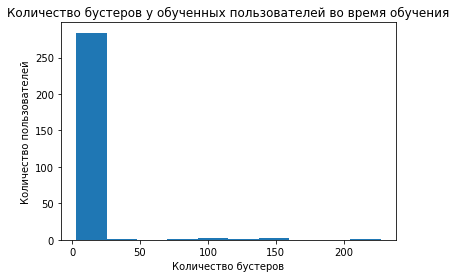

In [80]:
# Количество бустеров во время обучения у дошедших до конца обучения
x=[]
for i, user in enumerate(LearningArray): 
    x.append(user.event_name.where(user.event_name=="getBooster").count())   
arr = []
for value in x:
    if value < 50: 
        arr.append(value)
plt.hist(x, bins = 10)
plt.xlabel('Количество бустеров')
plt.ylabel('Количество пользователей')
plt.title('Количество бустеров у обученных пользователей во время обучения')
np.mean(x)

39.39375

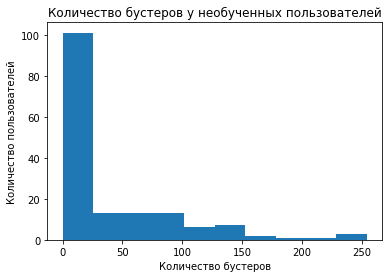

In [78]:
# Количество бустеров во время обучения у не дошедших до конца обучения
x=[]
for i, user in enumerate(UnlearnedArray): 
    x.append(user.event_name.where(user.event_name=="getBooster").count())  
arr = []
for value in x:
    if value < 50: 
        arr.append(value)
plt.hist(x, bins = 10)
plt.xlabel('Количество бустеров')
plt.ylabel('Количество пользователей')
plt.title('Количество бустеров у необученных пользователей')
np.mean(x)

66.06164383561644

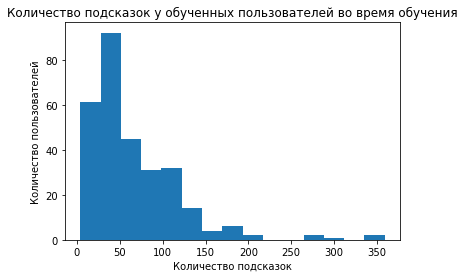

In [76]:
# Количество подсказок на время обучения у дошедших до конца обучения
x=[]
for i, user in enumerate(LearningArray): 
    x.append(user.event_name.where(user.event_name=="learning").count())
plt.hist(x, bins = 15)
plt.xlabel('Количество подсказок')
plt.ylabel('Количество пользователей')
plt.title('Количество подсказок у обученных пользователей во время обучения')
np.mean(x)

23.73125

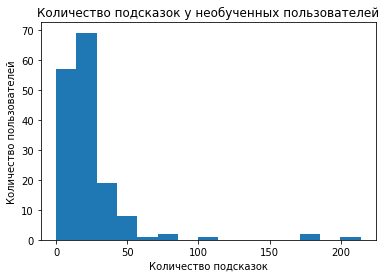

In [49]:
# Количество подсказок на время обучения у не дошедших до конца обучения
x=[]
for i, user in enumerate(UnlearnedArray): 
    x.append(user.event_name.where(user.event_name=="learning").count())
plt.hist(x, bins = 15)
plt.xlabel('Количество подсказок')
plt.ylabel('Количество пользователей')
plt.title('Количество подсказок у необученных пользователей')
np.mean(x)

In [54]:
losedunlearned=[]
losedlearned=[]
for user in UnlearnedArray:
    buff = view_data('win', user.where(data.event_name == 'levelEnd').dropna(how='all'))
    losedunlearned.append(buff.count('DEFEAT'))
for user in LearningArray:
    buff = view_data('win', user.where(data.event_name == 'levelEnd').dropna(how='all'))
    losedlearned.append(buff.count('DEFEAT'))

Text(0.5, 1.0, 'Количество поражений у необученных пользователей')

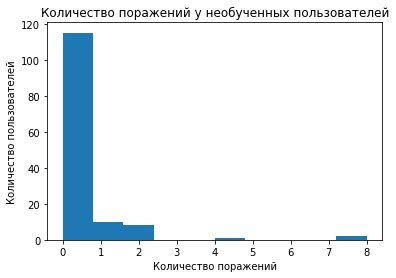

In [56]:
arr = []
for x in losedunlearned:
    if x < 10: 
        arr.append(x)
plt.hist(arr, bins = 10)
plt.xlabel('Количество поражений')
plt.ylabel('Количество пользователей')
plt.title('Количество поражений у необученных пользователей')

Text(0.5, 1.0, 'Количество поражений у обученных пользователей во время обучения')

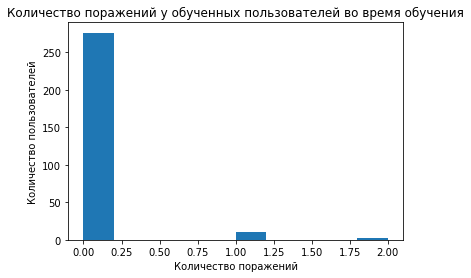

In [77]:
arr = []
for x in losedlearned:
    if x < 10: 
        arr.append(x)
plt.hist(arr, bins = 10)
plt.xlabel('Количество поражений')
plt.ylabel('Количество пользователей')
plt.title('Количество поражений у обученных пользователей во время обучения')

Text(0.5, 1.0, 'Количество поражений у необученных пользователей')

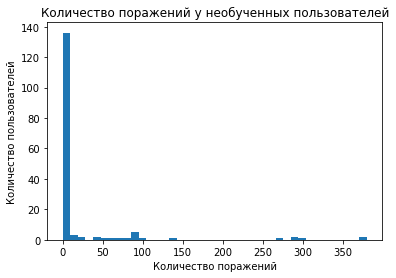

In [58]:
plt.hist(losedunlearned, bins = 40)
plt.xlabel('Количество поражений')
plt.ylabel('Количество пользователей')
plt.title('Количество поражений у необученных пользователей')

Text(0.5, 1.0, 'Количество поражений у обученных пользователей')

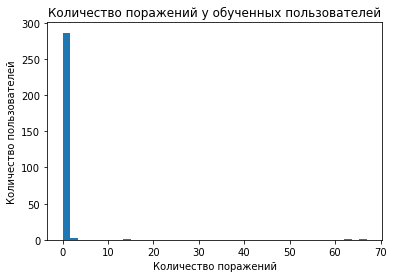

In [59]:
plt.hist(losedlearned, bins = 40)
plt.xlabel('Количество поражений')
plt.ylabel('Количество пользователей')
plt.title('Количество поражений у обученных пользователей')

In [60]:
DonateArray = []
adarray = []
for user in UserArray:
    if (user.media_source=='ad-traffic').values[0]==True:
        adarray.append(user.user_id.values[0].astype(int))

#### 159 Пользователей с рекламы. 

In [61]:
len(adarray)

159

#### CPI = 1.8 USD. С рекламы получено 56,57 USD.
#### Эффективность: 159 * 1.8 (затраты) - 56.57 (доход) = 229.63 (убыток за неделю).
#### При этом учитывается только недельная активность пользователей.
### -----

#### Для 21% игроков первая сессия оказалась последней. 

17.11283185840708
0.21017699115044255


Text(0.5, 1.0, 'Количество сессий по пользователям')

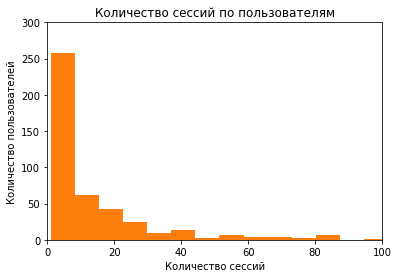

In [63]:
x=[]
for user in UserArray:
    x.append(np.max(user.session_index))
axes = plt.hist(x, bins = 452, density=True)
print(np.mean(x))
print(axes[0][0]/sum(axes[0]))
plt.axis([0, 100, 0, 300])
plt.hist(x, bins = 40)
plt.xlabel('Количество сессий')
plt.ylabel('Количество пользователей')
plt.title('Количество сессий по пользователям')

In [64]:
ans = []
for value in adarray:
    ans.append(InGameTimeCalculation(value, UserArray))

#### В среднем игроки с рекламы играют больше остальных 

In [65]:
np.array(ans).mean()

Timedelta('0 days 02:52:07.861635220')

#### Кривая игроков с рекламы убывает менее резко, игроки более лояльны. Для 17% от этих игроков первая сессия оказалось последней. В среднем больше сессий.

21.72327044025157
0.14465408805031446


Text(0.5, 1.0, 'Количество сессий у пользователей с рекламы')

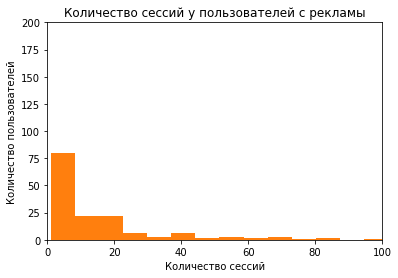

In [66]:
x=[]
for user in adarray:
    x.append(np.max(data.session_index.where(data.user_id==user)))
axes = plt.hist(x, bins = 452)
print(np.mean(x))
print(axes[0][0]/sum(axes[0]))
plt.axis([0, 100, 0, 200])
plt.hist(x, bins = 40)
plt.xlabel('Количество сессий')
plt.ylabel('Количество пользователей')
plt.title('Количество сессий у пользователей с рекламы')

## Retention

In [68]:
from datetime import datetime, timedelta

In [69]:
userdays=[]
end = max(data.client_time)
start = min(data.client_time)
date_generated = [start + timedelta(days=x) for x in range(0, (end-start).days + 2)]
for i in range((end-start).days):
    userdays.append(set(data.user_id.where(data.client_time > date_generated[i]).where(data.client_time < date_generated[i+1]).dropna(how='all').values))

0.5331858407079646
0.28761061946902655


Text(0.5, 1.0, 'Удержание пользователей по дням')

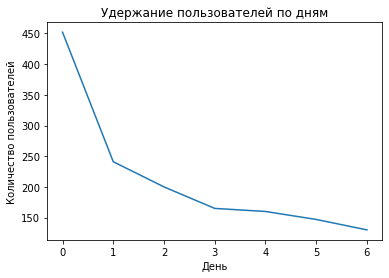

In [82]:
x=range(len(userdays))
y=[]
for i in x:
    y.append(len(userdays[i]))
plt.plot(x,y)
print(len(userdays[1])/len(userdays[0]))
print(len(userdays[-1])/len(userdays[0]))
plt.xlabel('День')
plt.ylabel('Количество пользователей')
plt.title('Удержание пользователей по дням')

In [194]:
x=range(len(userdays))
addays=[[],[],[],[],[],[],[]]
for i in x:
    for y in adarray:
        if (y in userdays[i]):
            addays[i].append(y)

0.5331858407079646
0.28761061946902655


Text(0.5, 1.0, 'Удержание пользователей с рекламы по дням')

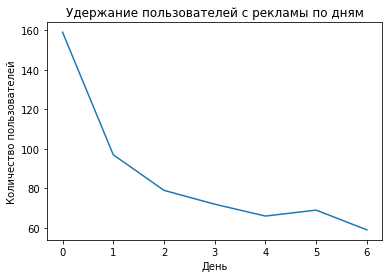

In [201]:
y=[]
for i in x:
    y.append(len(addays[i]))
plt.plot(x,y)
print(len(userdays[1])/len(userdays[0]))
print(len(userdays[-1])/len(userdays[0]))
plt.xlabel('День')
plt.ylabel('Количество пользователей')
plt.title('Удержание пользователей с рекламы по дням')